# Power spectal density analysis using full frame data
* 4/13/24 setup
* 4/13/2024 single dendritic dataset

In [1]:
from os.path import join, dirname
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch
import pandas as pd

# from ydata_profiling import ProfileReport
# from src import eeg_class as ec
from src import full_frame_analysis as ffa

# from src.classes import database
from src import full_frame_analysis as ffa
from src.classes.imaging_data_class import ImagingData
from src.clustering import interval_length_calculator as ilc
from src.clustering import process_dfof_intervals as pdi

import plotly.graph_objects as go


def open_and_convert(path):
    raw_ff_data = pd.read_csv(
        join(sima_folder, "s2p_ff/suite2p/plane0/reg_tif/ff_data.csv")
    )
    return raw_ff_data.convert_dtypes()

In [211]:
# db = database.ExperimentDatabase()
# dendritic_trials = [927, 935, 934, 929, 936, 931, 937, 932]
# somatic_trials = [745, 740, 749, 762, 761, 760, 885, 890]

In [212]:
mice = ["140503_2", "140503_3", "140502_5", "140302_3"]

In [213]:
mouse = ImagingData(mice[3])
mouse.mouse_id
s2p_folders = mouse.find_s2p_folders()
for folder in enumerate(s2p_folders):
    print(folder)

Looking for Suite2p folders in /data2/gergely/invivo_DATA/sleep/140302_3
(0, '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-001/TSeries-12212023-1051-001.sima/suite2p')
(1, '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-002/TSeries-12212023-1051-002.sima/suite2p')
(2, '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess01-001/TSeries-12112023-0825_sess01-001_Cycle00001_Element00001.sima/suite2p')
(3, '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess02_MC-002/TSeries-12112023-0825_sess02_MC-002.sima/suite2p')
(4, '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_MC-003/TSeries-12132023-0849_GC_MC-003.sima/suite2p.bak')
(5, '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_MC-003/TSeries-12132023-0849_GC_MC-003.sima/suite2p')
(6, '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_dendrite-004/TSeries-12132023-0849_GC_dendr

In [214]:
s2p_folder = s2p_folders[12]
sima_folder = dirname(s2p_folder)
sima_folder

'/data2/gergely/invivo_DATA/sleep/140302_3/1_18/TSeries-01182024-0805-003/TSeries-01182024-0805-003.sima'

In [216]:
somatic = open_and_convert(sima_folder)
somatic_dfof = somatic["DeltaF_F"]

mob_intervals = ilc(somatic, "mob_immob", 1)
immob_intervals = ilc(somatic, "mob_immob", 0)

mob_threshold = mob_intervals.loc[mob_intervals["length"] < 610, "n"].values
immob_threshold = immob_intervals.loc[immob_intervals["length"] < 610, "n"].values

thresholded_mob = (
    mob_intervals.loc[mob_intervals["n"].isin(mob_threshold)]
    .reset_index(drop=True)
    .copy()
)
thresholded_immob = (
    immob_intervals.loc[immob_intervals["n"].isin(immob_threshold)]
    .reset_index(drop=True)
    .copy()
)

mob_intervals = pdi(somatic_dfof, thresholded_mob)
immob_intervals = pdi(somatic_dfof, thresholded_immob)
mob_intervals.shape, immob_intervals.shape

((1, 10073), (1, 5349))

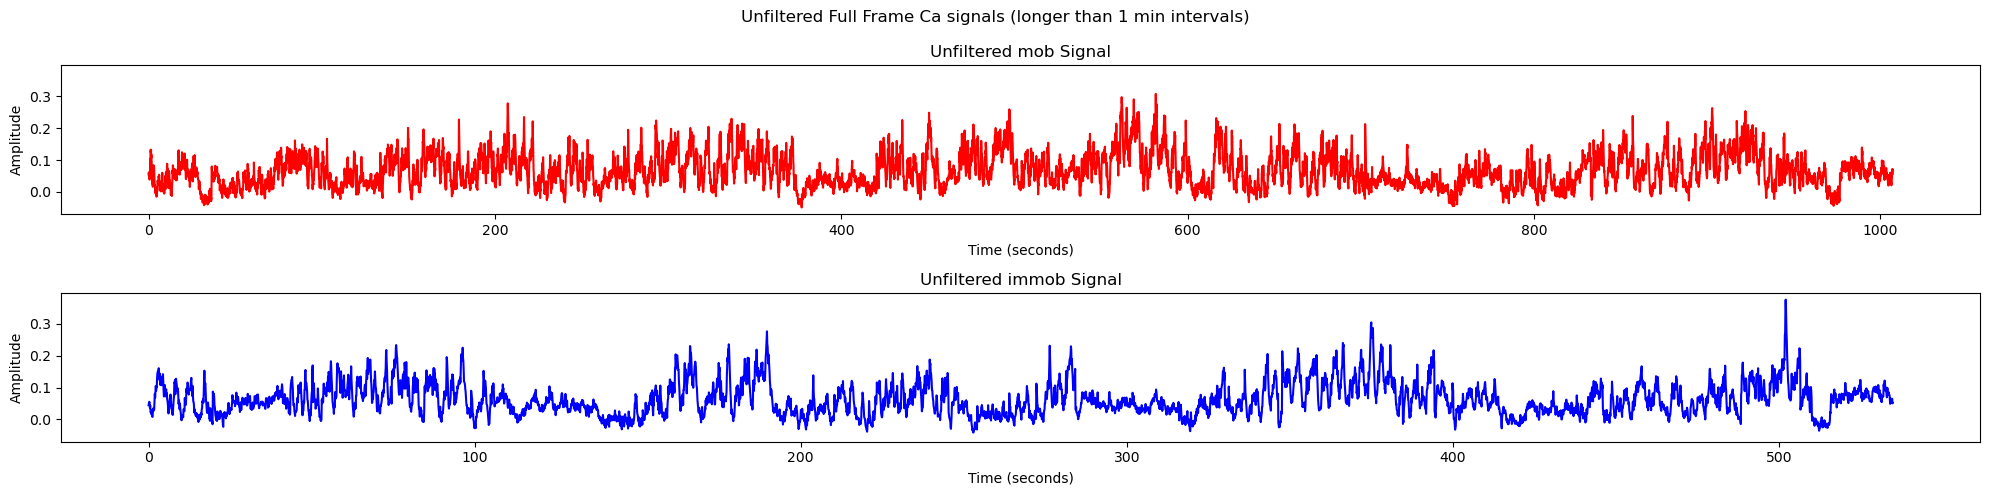

In [217]:
raw_mob = pd.Series(mob_intervals.iloc[0].values)
raw_immob = pd.Series(immob_intervals.iloc[0].values)

# Calculate the time vector for the x-axis (in seconds)
nrem_time = np.linspace(0, len(raw_mob) / 10, num=len(raw_mob))
awake_time = np.linspace(0, len(raw_immob) / 10, num=len(raw_immob))

# Create subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 5), sharey=True)
fig.suptitle("Unfiltered Full Frame Ca signals (longer than 1 min intervals)")

# Plot the filtered NREM data with time on the x-axis
ax[0].plot(nrem_time, raw_mob, color="red")
ax[0].set_title("Unfiltered mob Signal")
ax[0].set_xlabel("Time (seconds)")
ax[0].set_ylabel("Amplitude")

# Plot the filtered Awake data with time on the x-axis
ax[1].plot(awake_time, raw_immob, color="blue")
ax[1].set_title("Unfiltered immob Signal")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("Amplitude")

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap
fig.savefig(join(sima_folder, "Unfiltered ff signals.png"), dpi=300)
plt.show()

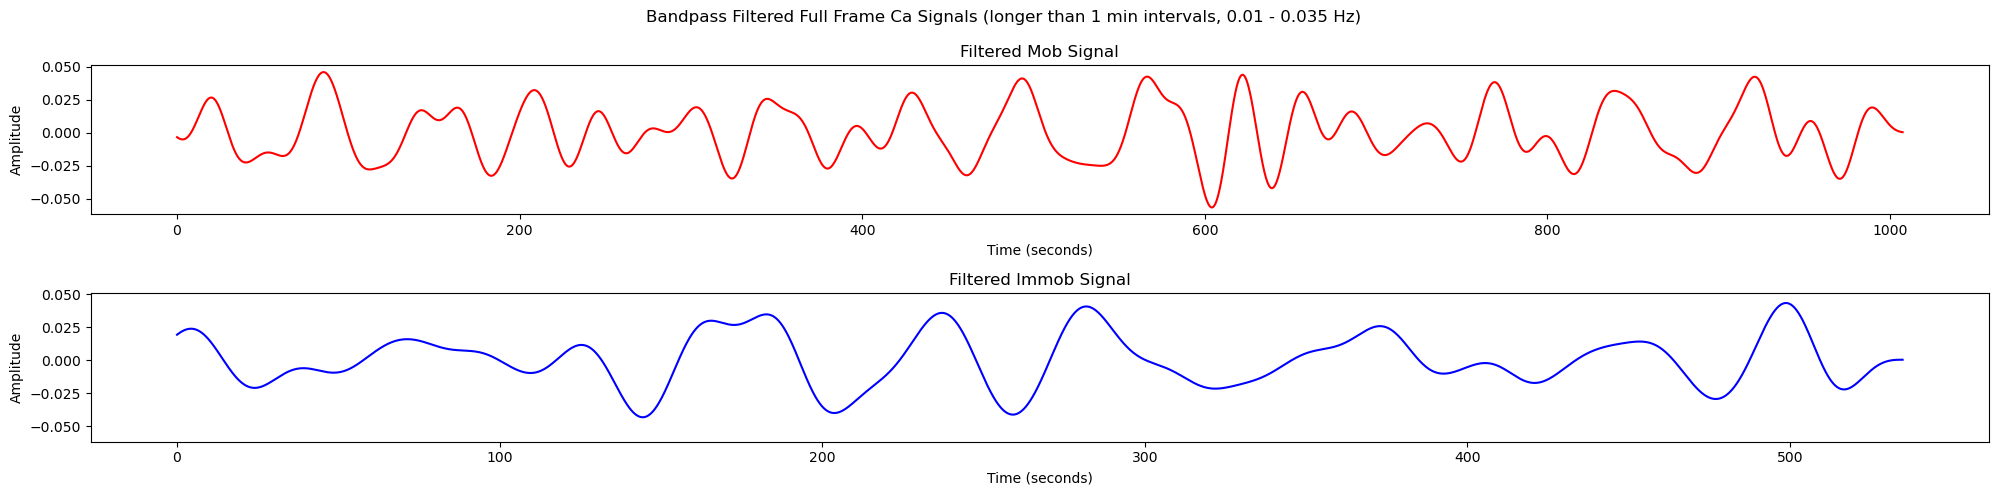

In [218]:
filt_mob = ffa.bandpass_filter_with_padding(raw_mob, 0.01, 0.035, 10)
filt_immob = ffa.bandpass_filter_with_padding(raw_immob, 0.01, 0.035, 10)

# Calculate the time vector for the x-axis (in seconds)
mob_time = np.linspace(0, len(filt_mob) / 10, num=len(filt_mob))
immob_time = np.linspace(0, len(filt_immob) / 10, num=len(filt_immob))

# Create subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 5), sharey=True)
fig.suptitle(
    "Bandpass Filtered Full Frame Ca Signals (longer than 1 min intervals, 0.01 - 0.035 Hz)"
)

# Plot the filtered NREM data with time on the x-axis
ax[0].plot(mob_time, filt_mob, color="red")
ax[0].set_title("Filtered Mob Signal")
ax[0].set_xlabel("Time (seconds)")
ax[0].set_ylabel("Amplitude")

# Plot the filtered Awake data with time on the x-axis
ax[1].plot(immob_time, filt_immob, color="blue")
ax[1].set_title("Filtered Immob Signal")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("Amplitude")

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(join(sima_folder, "Bandpass ff signals.png"), dpi=300)
plt.show()

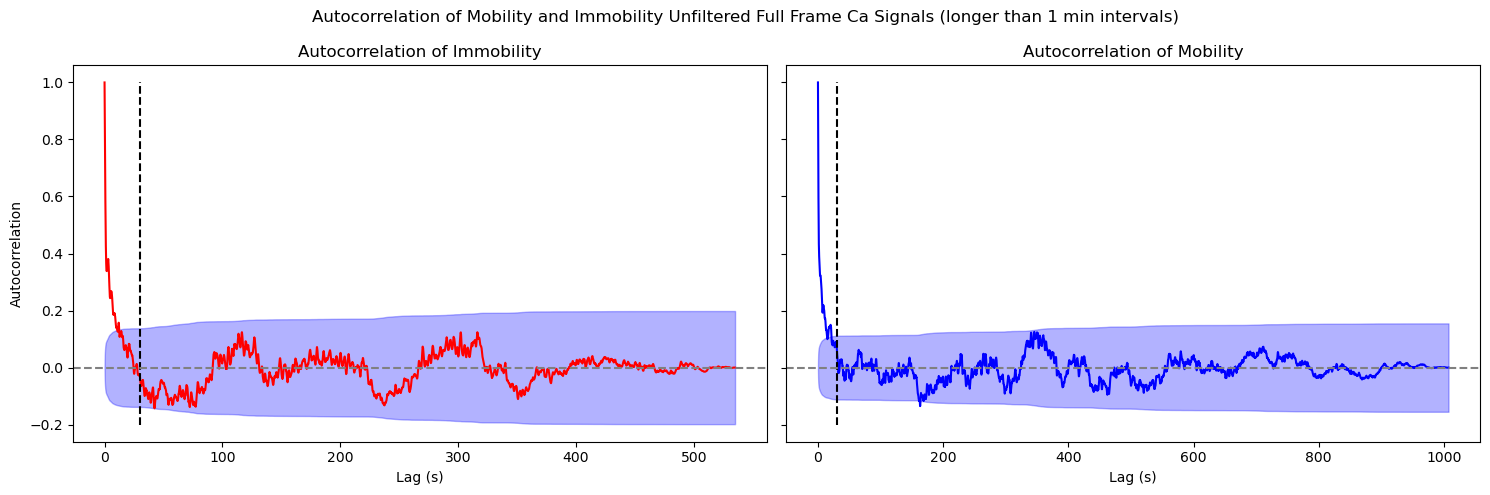

In [219]:
acf_immob, ci_immob = ffa.autocorrelation(raw_immob)
acf_immob_time = np.linspace(0, len(acf_immob) / 10, num=len(acf_immob))
acf_mob, ci_mob = ffa.autocorrelation(raw_mob)
acf_mob_time = np.linspace(0, len(acf_mob) / 10, num=len(acf_mob))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
fig.suptitle(
    "Autocorrelation of Mobility and Immobility Unfiltered Full Frame Ca Signals (longer than 1 min intervals)"
)

# Plot autocorrelation for raw_immob
ax[0].plot(acf_immob_time, acf_immob, color="red")
ax[0].set_title("Autocorrelation of Immobility")
ax[0].set_xlabel("Lag (s)")
ax[0].set_ylabel("Autocorrelation")
ax[0].fill_between(
    acf_immob_time,
    ci_immob[:, 0] - acf_immob,
    ci_immob[:, 1] - acf_immob,
    color="blue",
    alpha=0.3,
)
ax[0].vlines(30, -0.2, 1, color="black", linestyle="--")
ax[0].axhline(y=0, linestyle="--", color="gray")

# Plot autocorrelation for raw_mob
ax[1].plot(acf_mob_time, acf_mob, color="blue")
ax[1].set_title("Autocorrelation of Mobility")
ax[1].set_xlabel("Lag (s)")
ax[1].fill_between(
    acf_mob_time,
    ci_mob[:, 0] - acf_mob,
    ci_mob[:, 1] - acf_mob,
    color="blue",
    alpha=0.3,
)
ax[1].vlines(30, -0.2, 1, color="black", linestyle="--")
ax[1].axhline(y=0, linestyle="--", color="gray")
# ax[1].set_ylabel('Autocorrelation')  # Not needed, shared y-axis

# Enhance layout
plt.tight_layout()
fig.savefig(
    join(sima_folder, "Autocorrelation Mob_immob unfiltered ff signals.png"), dpi=300
)
plt.show()

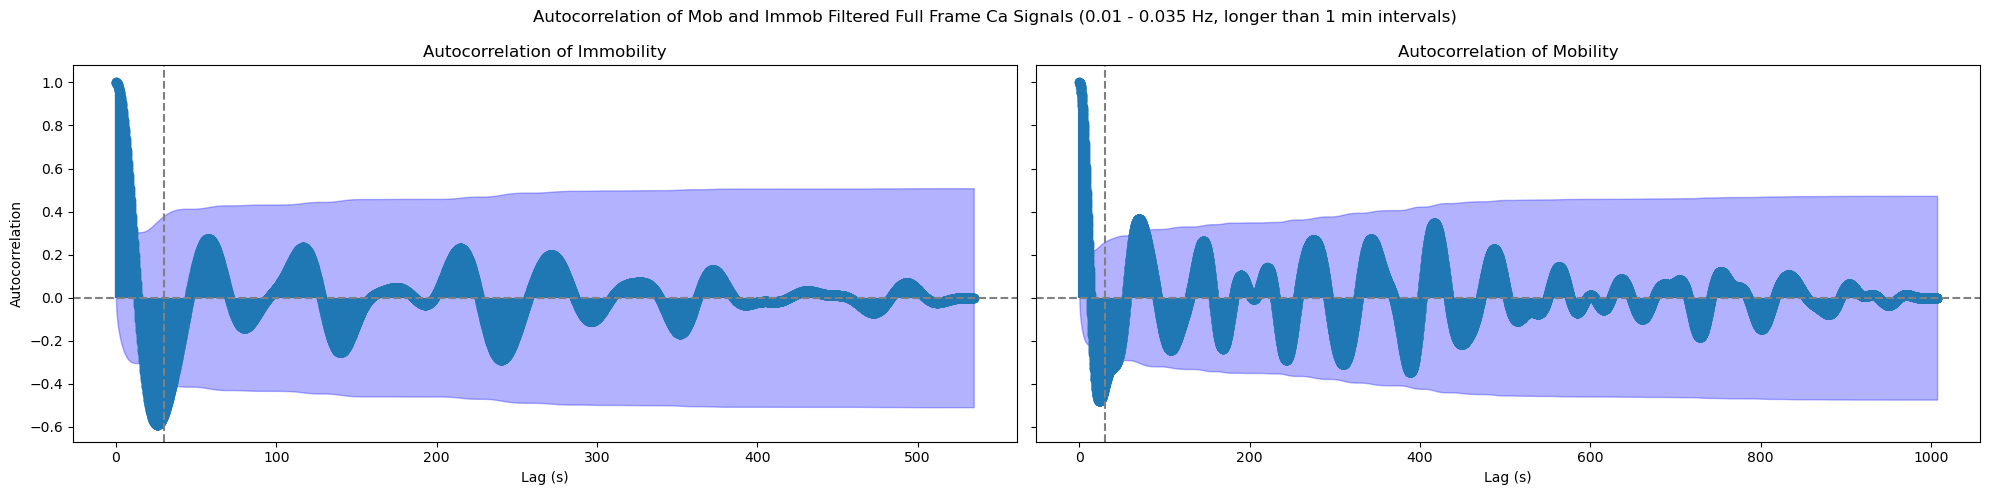

In [220]:
# filtered signals
filt_acf_immob, filt_ci_immob = ffa.autocorrelation(filt_immob)
filt_acf_immob_time = np.linspace(0, len(filt_acf_immob) / 10, num=len(filt_acf_immob))
filt_acf_mob, filt_ci_mob = ffa.autocorrelation(filt_mob)
filt_acf_awake_time = np.linspace(0, len(filt_acf_mob) / 10, num=len(filt_acf_mob))


# Set up the figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey=True)
fig.suptitle(
    "Autocorrelation of Mob and Immob Filtered Full Frame Ca Signals (0.01 - 0.035 Hz, longer than 1 min intervals)"
)

# Plot autocorrelation for filt_immob
axs[0].stem(filt_acf_immob_time, filt_acf_immob, basefmt=" ")
axs[0].fill_between(
    filt_acf_immob_time,
    filt_ci_immob[:, 0] - filt_acf_immob,
    filt_ci_immob[:, 1] - filt_acf_immob,
    color="blue",
    alpha=0.3,
)
axs[0].set_title("Autocorrelation of Immobility")
axs[0].set_xlabel("Lag (s)")
axs[0].set_ylabel("Autocorrelation")
axs[0].axhline(y=0, linestyle="--", color="gray")
axs[0].axvline(x=30, linestyle="--", color="gray")

# Plot autocorrelation for filt_mob
axs[1].stem(filt_acf_awake_time, filt_acf_mob, basefmt=" ")
axs[1].fill_between(
    filt_acf_awake_time,
    filt_ci_mob[:, 0] - filt_acf_mob,
    filt_ci_mob[:, 1] - filt_acf_mob,
    color="blue",
    alpha=0.3,
)
axs[1].set_title("Autocorrelation of Mobility")
axs[1].set_xlabel("Lag (s)")
axs[1].axhline(y=0, linestyle="--", color="gray")
axs[1].axvline(x=30, linestyle="--", color="gray")

# Enhance layout and display the plot
plt.tight_layout()
# fig.savefig(
# join(sima_folder, "Autocorrelation Filtered Mob Immob ff signals.png"), dpi=300
# )
plt.show()

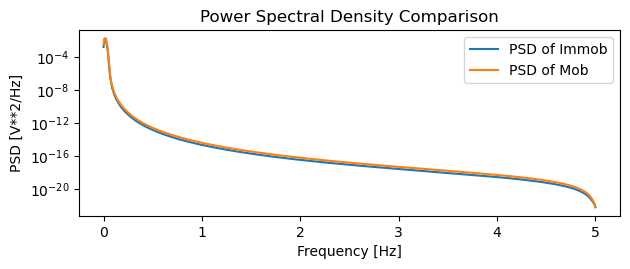

In [221]:
# Frequency Domain Analysis (Power Spectral Density)
fs = 10.0
f1, Pxx_den1 = welch(filt_immob, fs, nperseg=1024)
f2, Pxx_den2 = welch(filt_mob, fs, nperseg=1024)
plt.subplot(2, 1, 2)
plt.semilogy(f1, Pxx_den1, label="PSD of Immob")
plt.semilogy(f2, Pxx_den2, label="PSD of Mob")
plt.title("Power Spectral Density Comparison")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.legend()
plt.tight_layout()
plt.show()

# Coherence Analysis
# f, Cxy = coherence(filt_immob, filt_mob, fs, nperseg=1024)
# plt.figure()
# plt.plot(f, Cxy)
# plt.title("Magnitude-Squared Coherence")
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Coherence")
# plt.show()

In [222]:
def plot_fft_comparison(freq1, mag1, freq2, mag2, label1="Signal 1", label2="Signal 2"):
    """
    Plot FFT magnitudes of two signals for comparison using Plotly.

    Args:
        freq1 (array): Frequencies for the first signal.
        mag1 (array): Magnitudes for the first signal.
        freq2 (array): Frequencies for the second signal.
        mag2 (array): Magnitudes for the second signal.
        label1 (str): Label for the first signal.
        label2 (str): Label for the second signal.
    """
    # Create the figure
    fig = go.Figure()

    # Add the first signal trace
    fig.add_trace(go.Scatter(x=freq1, y=mag1, mode="lines", name=label1))

    # Add the second signal trace
    fig.add_trace(go.Scatter(x=freq2, y=mag2, mode="lines", name=label2))

    # Update plot layout
    fig.update_layout(
        title="FFT Magnitude Comparison",
        xaxis_title="Frequency (Hz)",
        yaxis_title="Magnitude",
        yaxis_type="log",  # Use log scale for magnitude for better visibility
        xaxis=dict(
            range=[0, max(freq1[-1], freq2[-1])]
        ),  # Adjust x-axis to fit the data
    )

    # Show the plot
    fig.show()

In [223]:
fs = 10
t = np.linspace(0, 1, fs, endpoint=False)
immob_signal = filt_immob
mob_signal = filt_mob

immob_freq, immob_mag = ffa.calculate_fft(immob_signal, fs)
mob_freq, awake_mag = ffa.calculate_fft(mob_signal, fs)

plot_fft_comparison(immob_freq, immob_mag, mob_freq, awake_mag, "Immob", "Mob")

In [224]:
def plot_frequency_components(
    freq1, psd1, freq2, psd2, title1="Signal 1", title2="Signal 2"
):
    """
    Plot the main frequency components of two signals for comparison and return the figure object.

    Args:
        freq1 (np.array): Frequencies of the first signal.
        psd1 (np.array): PSD values of the first signal.
        freq2 (np.array): Frequencies of the second signal.
        psd2 (np.array): PSD values of the second signal.
        title1 (str): Title for the first signal plot.
        title2 (str): Title for the second signal plot.
    """
    # Create a figure object with a specific size
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot for the first signal
    axs[0].stem(freq1, psd1, linefmt="r-", markerfmt="ro", basefmt="r-")
    axs[0].set_title(title1)
    axs[0].set_xlabel("Frequency (Hz)")
    axs[0].set_ylabel("Power Spectral Density")
    axs[0].set_ylim(0, 2000)
    axs[0].grid(True)
    axs[0].fill_betweenx(y=[0, 2000], x1=0.01, x2=0.04, color="grey", alpha=0.3)

    # Plot for the second signal
    axs[1].stem(freq2, psd2, linefmt="b-", markerfmt="bo", basefmt="b-")
    axs[1].set_title(title2)
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Power Spectral Density")
    axs[1].set_ylim(0, 2000)
    axs[1].grid(True)
    axs[1].fill_betweenx(
        y=[0, 2000],
        x1=0.01,
        x2=0.04,
        color="grey",
        alpha=0.3,
    )

    # Set the super title for the figure
    fig.suptitle("Comparison of Main Frequency Components Unfiltered FF")
    plt.tight_layout()

    # Return the figure object
    return fig

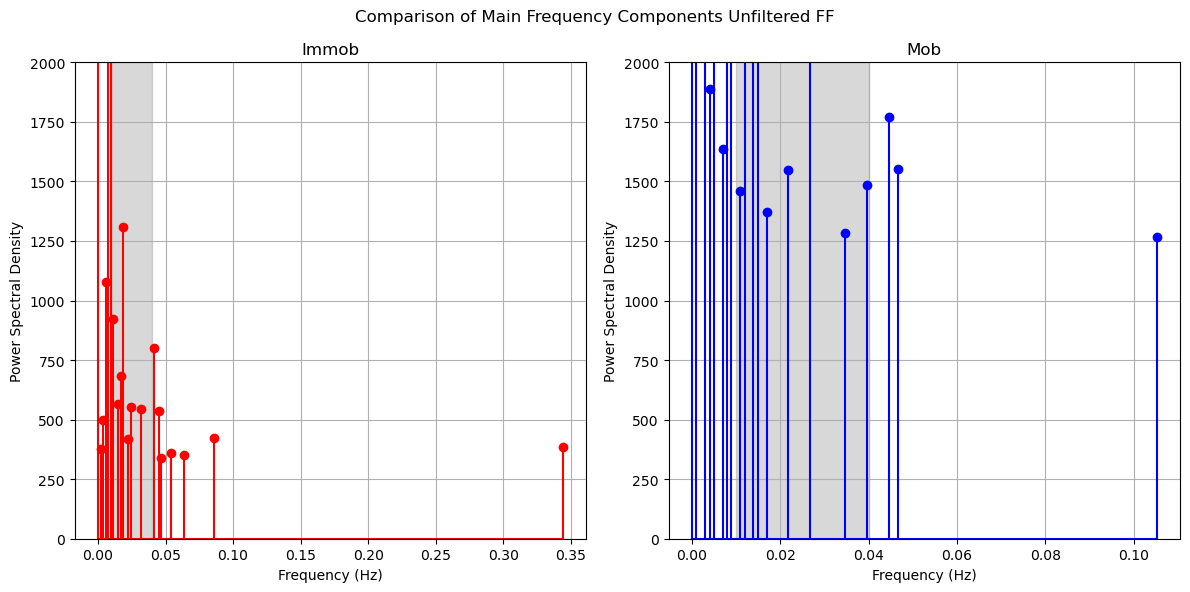

In [225]:
immob_signal = raw_immob
mob_signal = raw_mob
fs = 10.0

immob_freq, immob_psd = ffa.calculate_frequency_components(immob_signal, fs)
mob_freq, mob_psd = ffa.calculate_frequency_components(mob_signal, fs)

fig = plot_frequency_components(
    immob_freq, immob_psd, mob_freq, mob_psd, "Immob", "Mob"
)
fig.savefig(join(sima_folder, "Main Frequency Components raw ff signals.png"), dpi=300)

In [226]:
immob_mask = (immob_freq >= 0.01) & (immob_freq <= 0.035)
mob_mask = (mob_freq >= 0.01) & (mob_freq <= 0.035)
immob_filt_psd = immob_psd[immob_mask]
mob_filt_psd = mob_psd[mob_mask]

In [227]:
data_to_save = {
    "data_dir": sima_folder,
    "immob_filt_psd": [immob_filt_psd],
    "mob_filt_psd": [mob_filt_psd],
}

# Save the data to a CSV file
data_df = pd.DataFrame(data_to_save)
data_df.to_csv(join(sima_folder, "psd_data.csv"), index=False)

In [228]:
data_df

,data_dir,immob_filt_psd,mob_filt_psd
0,/data2/gergely/invivo_DATA/sleep/140302_3/1_18...,"[418.34349671354147, 544.4306734289954, 552.93...","[1281.9375105159493, 1372.2058935846762, 1460...."
